In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from math import cos, pi, radians
from numpy import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [4]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [5]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 9), (3888, 7))

In [ ]:
df_train[:48]

In [ ]:
df_train['theta'] = (list(cos(radians(np.array(range(1, 49)).astype(float)*7.5))) * int(df_train.shape[0]/48))
df_train

In [ ]:
display(df_train.describe())

In [ ]:
df_train.columns

In [ ]:
print(df_train['DNI'].skew())
print(np.log1p(df_train['DNI']).skew())
print(np.sqrt(df_train['DNI']).skew())

In [ ]:
sns.distplot(np.log1p(df_train['DNI']))

In [ ]:
plt.boxplot(df_train['DNI'])

In [ ]:
for col in ['TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']:
    plt.title(col)
    plt.boxplot(df_train[col])
    plt.show()

In [ ]:
for col in ['TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']:
    plt.title(col)
    sns.distplot(df_train[col])
    plt.show()

In [ ]:
df_train['DNI'] = np.log1p(df_train['DNI'])
df_test['DNI'] = np.log1p(df_test['DNI'])

In [6]:
min = df_train[['Hour','DHI','DNI','WS','RH','T']].min()
max  = df_train[['Hour','DHI','DNI','WS','RH','T']].max()

In [7]:
for i, col in enumerate(['Hour','DHI','DNI','WS','RH','T']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [ ]:
display(df_train.describe())
display(df_test.describe())

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_train[['Hour','DHI','DNI','WS','RH','T']] = scaler.fit_transform(df_train[['Hour','DHI','DNI','WS','RH','T']])
df_test[['Hour','DHI','DNI','WS','RH','T']] = scaler.fit_transform(df_test[['Hour','DHI','DNI','WS','RH','T']])

In [13]:
df_train

,Hour,TARGET,DHI,DNI,WS,RH,T,Target1,Target2
0,0.000000,0.0,0.0,0.0,0.125000,0.665404,0.129630,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.125000,0.665188,0.129630,0.0,0.0
2,0.043478,0.0,0.0,0.0,0.133333,0.694622,0.129630,0.0,0.0
3,0.043478,0.0,0.0,0.0,0.133333,0.694297,0.129630,0.0,0.0
4,0.086957,0.0,0.0,0.0,0.133333,0.731631,0.129630,0.0,0.0
...,...,...,...,...,...,...,...,...,...
52459,0.913043,0.0,0.0,0.0,0.291667,0.523536,0.333333,0.0,0.0
52460,0.956522,0.0,0.0,0.0,0.325000,0.504707,0.314815,0.0,0.0
52461,0.956522,0.0,0.0,0.0,0.341667,0.504491,0.314815,0.0,0.0
52462,1.000000,0.0,0.0,0.0,0.358333,0.528839,0.314815,0.0,0.0


In [15]:
Day  = df_train.iloc[:, :4]
#Day  = df_train.iloc[:, :-2]
#Day7 = df_train.iloc[:, -2]
#Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

In [14]:
df_train.iloc[:, 0:4]

,Hour,TARGET,DHI,DNI
0,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0
2,0.043478,0.0,0.0,0.0
3,0.043478,0.0,0.0,0.0
4,0.086957,0.0,0.0,0.0
...,...,...,...,...
52459,0.913043,0.0,0.0,0.0
52460,0.956522,0.0,0.0,0.0
52461,0.956522,0.0,0.0,0.0
52462,1.000000,0.0,0.0,0.0


In [44]:
Day.shape, Day78.shape

((52464, 4), (52464, 2))

In [17]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

In [18]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [19]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [20]:
from sklearn.model_selection import train_test_split

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day78, test_size=0.25, random_state=0)
#X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=0)

X_train_1.shape, X_valid_1.shape, Y_train_1.shape, Y_valid_1.shape

((39348, 4), (13116, 4), (39348, 2), (13116, 2))

In [90]:
model = tf.keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(Day.shape)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(2)
])

In [82]:
epoch = 100

In [83]:
model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train_1, Y_train_1, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid_1, Y_valid_1)

Epoch 1/100
615/615 [==============================] - 1s 1ms/step - loss: 471.1194 - val_loss: 196.2597
Epoch 2/100
615/615 [==============================] - 1s 1ms/step - loss: 179.6546 - val_loss: 175.3358
Epoch 3/100
615/615 [==============================] - 1s 1ms/step - loss: 169.9092 - val_loss: 168.8129
Epoch 4/100
615/615 [==============================] - 1s 1ms/step - loss: 161.8048 - val_loss: 163.7940
Epoch 5/100
615/615 [==============================] - 1s 1ms/step - loss: 159.5688 - val_loss: 160.7504
Epoch 6/100
615/615 [==============================] - 1s 1ms/step - loss: 156.1180 - val_loss: 161.1466
Epoch 7/100
615/615 [==============================] - 1s 1ms/step - loss: 155.6545 - val_loss: 158.8603
Epoch 8/100
615/615 [==============================] - 1s 1ms/step - loss: 154.1661 - val_loss: 157.0417
Epoch 9/100
615/615 [==============================] - 1s 1ms/step - loss: 151.1912 - val_loss: 160.0465
Epoch 10/100
615/615 [==============================] -

136.18516540527344

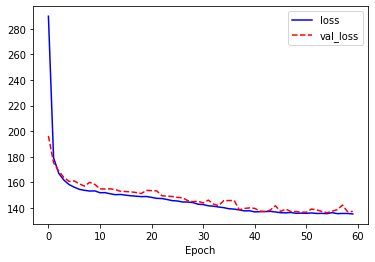

In [84]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [72]:
df_test.iloc[:, :4]

,Hour,TARGET,DHI,DNI
288,0.000000,0.0,0.0,0.0
289,0.000000,0.0,0.0,0.0
290,0.043478,0.0,0.0,0.0
291,0.043478,0.0,0.0,0.0
292,0.086957,0.0,0.0,0.0
...,...,...,...,...
331,0.913043,0.0,0.0,0.0
332,0.956522,0.0,0.0,0.0
333,0.956522,0.0,0.0,0.0
334,1.000000,0.0,0.0,0.0


In [91]:
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test.iloc[:, :4]))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 1.5397 - val_loss: 1.6256
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4295 - val_loss: 1.6247
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4209 - val_loss: 1.6218
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4181 - val_loss: 1.6224
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4321 - val_loss: 1.6218
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4245 - val_loss: 1.6301
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4317 - val_loss: 1.6271
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4414 - val_loss: 1.6212
Epoch 9/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4364 - val_loss: 1.6266
Epoch 10/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4499 - val_lo

820/820 [==============================] - 1s 1ms/step - loss: 2.2489 - val_loss: 2.5570
Epoch 36/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2712 - val_loss: 2.6034
Epoch 37/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2640 - val_loss: 2.6051
Epoch 38/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2851 - val_loss: 2.5679
Epoch 39/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2727 - val_loss: 2.5860
Epoch 40/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2790 - val_loss: 2.5504
Epoch 41/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2445 - val_loss: 2.5571
Epoch 42/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2429 - val_loss: 2.5697
Epoch 43/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2496 - val_loss: 2.5619
Epoch 44/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2342 - val_loss: 

820/820 [==============================] - 1s 1ms/step - loss: 2.8009 - val_loss: 3.1438
Epoch 13/100
820/820 [==============================] - 1s 1ms/step - loss: 2.8268 - val_loss: 3.1315
Epoch 14/100
820/820 [==============================] - 1s 1ms/step - loss: 2.8171 - val_loss: 3.1308
Epoch 15/100
820/820 [==============================] - 1s 1ms/step - loss: 2.8261 - val_loss: 3.1690
Epoch 16/100
820/820 [==============================] - 1s 1ms/step - loss: 2.7986 - val_loss: 3.1340
Epoch 00016: early stopping
Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 2.7378 - val_loss: 3.0260
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.7109 - val_loss: 3.0730
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.7184 - val_loss: 3.0544
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.7137 - val_loss: 3.0335
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - lo

820/820 [==============================] - 1s 1ms/step - loss: 2.0126 - val_loss: 2.2567
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 2.0134 - val_loss: 2.2179
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 2.0086 - val_loss: 2.2080
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 2.0305 - val_loss: 2.2207
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 2.0428 - val_loss: 2.2110
Epoch 9/100
820/820 [==============================] - 1s 1ms/step - loss: 2.0124 - val_loss: 2.2062
Epoch 10/100
820/820 [==============================] - 1s 1ms/step - loss: 2.0395 - val_loss: 2.2077
Epoch 11/100
820/820 [==============================] - 1s 1ms/step - loss: 1.9819 - val_loss: 2.2118
Epoch 12/100
820/820 [==============================] - 1s 1ms/step - loss: 2.0021 - val_loss: 2.2417
Epoch 13/100
820/820 [==============================] - 1s 1ms/step - loss: 2.0059 - val_loss: 2.213

(3888, 18)

In [92]:
results[0]

,0,0,0,0,0,0,0,0,0
0,-0.000837,-0.039923,-0.045247,0.010049,0.015852,0.000209,0.010112,-0.013026,0.105362
1,-0.000837,-0.039923,-0.045247,0.010049,0.015852,0.000209,0.010112,-0.013026,0.105362
2,-0.000411,-0.042111,-0.043603,0.008113,0.013845,-0.000008,0.010933,-0.009386,0.105730
3,-0.000411,-0.042111,-0.043603,0.008113,0.013845,-0.000008,0.010933,-0.009386,0.105730
4,0.000040,-0.043800,-0.040414,0.008481,0.013972,0.000591,0.011752,-0.005745,0.106097
...,...,...,...,...,...,...,...,...,...
3883,-0.001704,-0.049501,-0.003235,0.002799,0.001767,0.002961,0.046531,0.010257,0.059479
3884,-0.001638,-0.049620,-0.002996,0.001594,0.002424,0.004327,0.048645,0.011374,0.062236
3885,-0.001638,-0.049620,-0.002996,0.001594,0.002424,0.004327,0.048645,0.011374,0.062236
3886,-0.001572,-0.047543,-0.005344,0.000389,0.003080,0.005693,0.050760,0.012492,0.064994


In [93]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results[0].sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results[1].sort_index().values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,-0.000837,-0.039923,-0.045247,0.010049,0.015852,0.000209,0.010112,-0.013026,0.105362
1,0.csv_Day7_0h30m,-0.000837,-0.039923,-0.045247,0.010049,0.015852,0.000209,0.010112,-0.013026,0.105362
2,0.csv_Day7_1h00m,-0.000411,-0.042111,-0.043603,0.008113,0.013845,-0.000008,0.010933,-0.009386,0.105730
3,0.csv_Day7_1h30m,-0.000411,-0.042111,-0.043603,0.008113,0.013845,-0.000008,0.010933,-0.009386,0.105730
4,0.csv_Day7_2h00m,0.000040,-0.043800,-0.040414,0.008481,0.013972,0.000591,0.011752,-0.005745,0.106097
5,0.csv_Day7_2h30m,0.000040,-0.043800,-0.040414,0.008481,0.013972,0.000591,0.011752,-0.005745,0.106097
6,0.csv_Day7_3h00m,-0.000755,-0.045489,-0.037225,0.008848,0.014100,0.001190,0.012573,-0.002104,0.106466
7,0.csv_Day7_3h30m,-0.000755,-0.045489,-0.037225,0.008848,0.014100,0.001190,0.012573,-0.002104,0.106466
8,0.csv_Day7_4h00m,-0.001550,-0.047177,-0.034036,0.009216,0.014227,0.001790,0.013394,0.001537,0.106836
9,0.csv_Day7_4h30m,-0.001550,-0.047177,-0.034036,0.009216,0.014227,0.001790,0.013394,0.001537,0.106836


In [94]:
submission.to_csv('./submission/submission_20210117-3.csv', index=False)